#### Overview

The `Metropolis` algorithm allows us to generate samples from a distribution without needing to know the `normalizing factor`, as long as we know the expression of any unnormalized version of a probability distribution

To see what this means, we again consider the following expression

$$f(x) = \exp(-x^{2})(2 + \sin(3x) + \sin(4x)), \quad \text{for } x \in [0, 3]$$

and we normalize it to turn it into a valid probability distribution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from scipy.integrate import quad
import time
plt.style.use('dark_background')
np.set_printoptions(formatter={'float': '{: 0.4f}'.format})

In [2]:
# Unnormalized distribution
def target_pdf(x):
    return np.exp(-x**2) * (2 + np.sin(3 * x) + np.sin(4 * x))

# Compute normalizing factor using numerical integration
normalizing_factor, _ = quad(target_pdf, 0, 3)

# Normalized distribution
def normalized_pdf(x):
    return target_pdf(x) / normalizing_factor

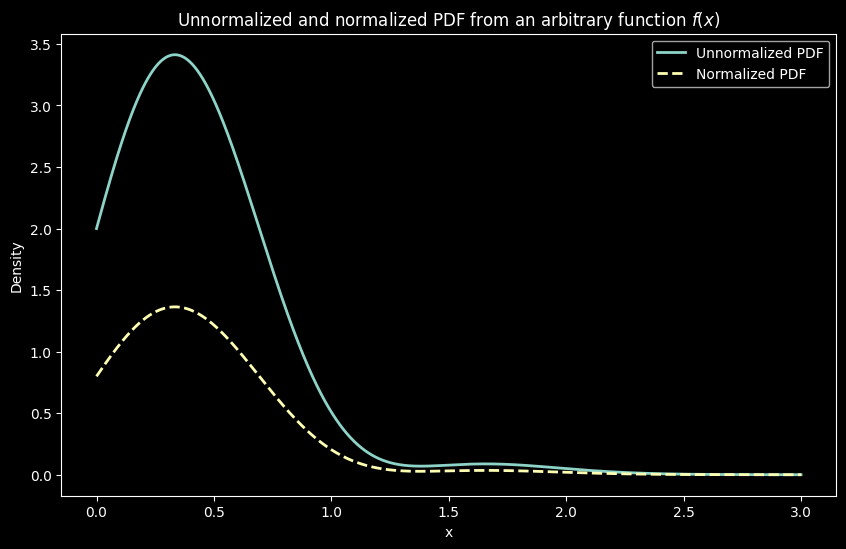

In [3]:
x = np.linspace(0, 3, 1000)
y_unnormalized = target_pdf(x)
y_normalized = normalized_pdf(x)

plt.figure(figsize=(10, 6))
plt.plot(x, y_unnormalized, label='Unnormalized PDF', linewidth=2)
plt.plot(x, y_normalized, label='Normalized PDF', linewidth=2, linestyle='--')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.title('Unnormalized and normalized PDF from an arbitrary function $f(x)$')
plt.show()

#### `Metropolis` algorithm

1. **Initialization**: Start with an empty sample list, start with an initial, guessed sample $x_0$
2. **Proposal**: Generate a candidate new sample $x_*$ from a `proposal distribution` $q(x_*|x_0)$
3. **Acceptance probability**: Compute `acceptance probability` of $x_*$
   $$\alpha = \min\left(1, \frac{f(x_*)}{f(x_0)}\right)$$
Importance of using ratio of $\frac{f(x_*)}{f(x_0)}$ is that, even $f$ is `unnormalized`, the needed normalizing factors in numerator and denominator would cancel out each other, making the algorithm perfectly suited for expression of unnormalized distribution

4. **Acceptance or rejection**: Accept $x_*$ as new sample with `probability` $\alpha$
5. **Add to list**: If $x_*$ is `accepted`, add $x_*$ to sample list, and then set $x_*$ as the new $x_0$ for next iteration; `otherwise`, add $x_0$ to sample list
6. **Iteration**: Repeat steps 2-5

Mathematical proof of why it works can be found here
https://gregorygundersen.com/blog/2019/11/02/metropolis-hastings/

`Intuitively`, the Metropolis algorithm promotes sampling `more easily from regions of higher probability`, while `decreasing the chance of sampling from regions of lower probability`. If $x_*$ is in a higher probability region than $x_0$, then the algorithm moves to the region of $x_*$. However, if $x_*$ is in a lower probability region than $x_0$, then the algorithm moves to the region of $x_*$ with a reduced chance that is proportional to $\frac{f(x_*)}{f(x_0)}$


#### `Proposal distribution`

In Metropolis, a candidate new sample $x_*$ is produced from the current sample $x_0$ using a proposal distribution

One of the common choices is Gaussian distribution. Specifically

$$q(x_*|x_0)=\frac{1}{\sqrt{2\pi}\sigma}e^{-\frac{(x_*-x_0)^2}{2\sigma^2}}$$

This is a function of $x_*$ that follows a Gaussian curve with a `mean` of $x_0$ and a `standard deviation` $\sigma$

In Metropolis, the standard deviation is also referred to as `step size`. Determine suited `step size` is required for sampling to perform as desired

There are many research on how to determine the step size for Metropolis, which are not the focus here

Note, if the proposal distribution is `not symmetric`, Metropolis algorithm needs to be adjusted by additional terms, known as `Metropolis-Hastings` algorithm

Gaussian distribution is a symmetric distribution, so we don't have to worry here

#### Acceptance rate

Rule of thumb, we don't want acceptance rate either too low or too high, somewhere in 20~40%

In [4]:
# Metropolis algorithm
def metropolis_sampling(pdf, x0, n_samples, step_size):
    # Create sample list
    samples = []
    # Create first guess
    x = x0

    accepted = 0

    for i in range(n_samples):
        # Generate new candidate x_new using Gaussian as proposal distribution
        x_new = x + np.random.normal(scale=step_size)

        # Ensure x_new is within the defined range
        if 0 <= x_new <= 3:

            # Compute acceptance probability
            acceptance_prob = pdf(x_new) / pdf(x)

            # Take a random number from [0, 1], compared to acceptance probability
            if np.random.rand() < acceptance_prob:
                # If random number is smaller, then accept x_new and assign it to x
                # This approximates the scenario of accepting x_new with acceptance probability
                x = x_new
                accepted += 1

        # Add new sample or previous sample to sample list, depending on the comparison
        samples.append(x)

    acceptance_rate = accepted / n_samples
    print(f'Accepted: {accepted}')
    print(f"Metropolis acceptance rate: {acceptance_rate:.2f}")

    return np.array(samples)

Accepted: 2319
Metropolis acceptance rate: 0.23
(10000,)
Metropolis sampling time: 0.42 seconds


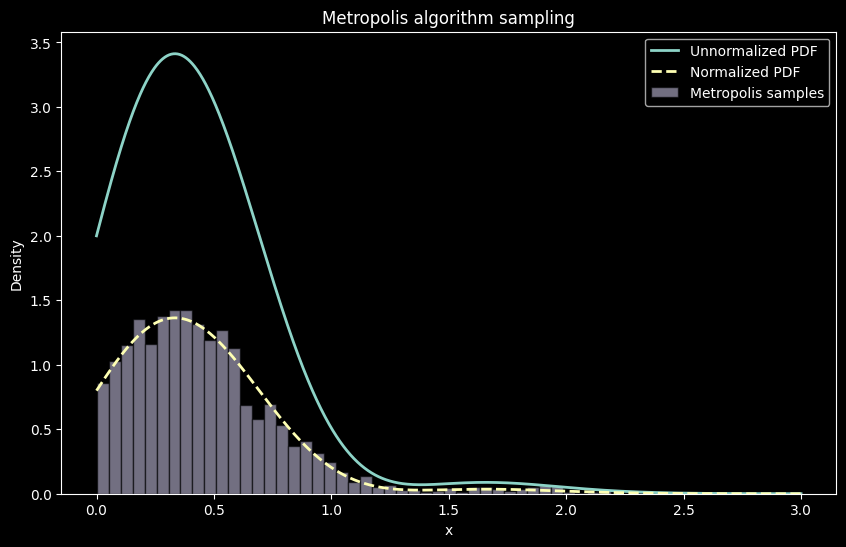

In [6]:
x0 = 1.0  # Initial guess
n_samples = 10000  # Number of samples
step_size = 1.5

# Metropolis to sample from unnormalized PDF directly
start_time = time.time()
samples = metropolis_sampling(target_pdf, x0, n_samples, step_size)
print(samples.shape)
print(f"Metropolis sampling time: {time.time() - start_time:.2f} seconds")

x = np.linspace(0, 3, 1000)
y_unnormalized = target_pdf(x)
y_normalized = normalized_pdf(x)

plt.figure(figsize=(10, 6))
plt.plot(x, y_unnormalized, label='Unnormalized PDF', linewidth=2)
plt.plot(x, y_normalized, label='Normalized PDF', linewidth=2, linestyle='--')
plt.hist(samples, bins=50, density=True, alpha=0.6, label='Metropolis samples', edgecolor='black')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.title('Metropolis algorithm sampling')
plt.show()

We can see, the samples taken by Metropolis algorithm form a `histogram` that resembles normalized distribution

Compared to results from Laplace's method (from previous notes), Metropolis algorithm is a more suited choice for this distribution $f(x)$